# Analysis of the L1-21J impact event on the Moon

*"Location, orbit and energy of a meteoroid impacting the moon during the Lunar Eclipse of January 21, 2019* by Jorge I. Zuluaga, Pablo A. Cuartas, Jonathan Ospina, Matipon Tangmatitham, Sergio López, Fritz Pichardo & Karl Peña

In [1]:
BDIR="./"

## Preparing the Environment

Please skip if you are working on a Jupyter environment

In [4]:
#ENVIRONMENT="Colaboratory"
ENVIRONMENT="Jupyter"
DATADIR="MoonFlashes"

In [5]:
if ENVIRONMENT=="Colaboratory":
  try:
    import spiceypy
  except:
    !pip install spiceypy
  from google.colab import drive,files
  drive.mount('/content/gdrive')
  
  BDIR=f"gdrive/My Drive/{DATADIR}/"
else:
  BDIR="./"
from glob import glob 
if len(glob(f"{BDIR}/data"))==0:
  print("You are not in the proper directory.  Please correct")
else:
  print("Home, sweet home")

Home, sweet home


## External modules, constants and useful routines

### External modules and macros

In [6]:
###################################################################
#EXTERNAL MODULES
###################################################################
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pandas as pd
from scipy.optimize import minimize
from scipy import optimize
from scipy.interpolate import interp1d as interpolate
from scipy.integrate import quad as integrate
import statistics as stats
import spiceypy as spy
from copy import deepcopy
from tqdm import tqdm
from collections import OrderedDict
import math

if ENVIRONMENT=="Colaboratory":
    %matplotlib inline
else:
    %matplotlib nbagg

###################################################################
#INITIALIZE SPICE
###################################################################
spy.furnsh(BDIR+"kernels/de430.bsp")
spy.furnsh(BDIR+"kernels/naif0012.tls")
spy.furnsh(BDIR+"kernels/pck00010.tpc")
spy.furnsh(BDIR+"kernels/moon_pa_de421_1900-2050.bpc")

#Useful package routines
norm=np.linalg.norm

### Constants and Macros

In [7]:
###################################################################
#NUMERICAL
###################################################################
#Angle conversion
DEG=np.pi/180
RAD=1/DEG

###################################################################
#PHYSICAL 
###################################################################
#Tons of TNT
TTNT=4.184e9 #J

#Regolith density
RHO_REG=1600 #kg/m^3

#Density of bodies
RHO_COMET=1000
P_COMET=0.01
RHO_ROCKY=2500
P_ROCKY=0.59
RHO_METAL=3700
P_METAL=1-P_COMET-P_ROCKY

###################################################################
#IMPACT DATA
###################################################################
IMPACT_DATA="L1-21J"
IMPACT_SUFFIX="lat_-2.94288e+01__lon_-6.81674e+01"
IMPACT_FIGDIR=f"{BDIR}/data/{IMPACT_DATA}"
IMPACT_LOC=dict(
    lon=-29.428816, #degrees, 29°25'43.74"S
    lat=-68.167435, #degrees, 68°10'2.77"O
    alt=0.510 #km
)
IMPACT_FLASH=0.30
IMPACT_DATE="01/21/2019"
IMPACT_TIME="04:41:38 UTC"

#Ephemeris Time
t=spy.str2et(IMPACT_DATE+" "+IMPACT_TIME)
dt=spy.deltet(t,"et")
IMPACT_ET=t-dt
print(f"Time of the eclipse: {IMPACT_DATE} (TDB = {IMPACT_ET}, Delta t = {dt}")

#Sideral time at the moment of the impact
GST=12.71279 #H

###################################################################
#ASTRONOMICAL CONDITIONS
###################################################################
moonpos,tf=spy.spkezr("MOON",IMPACT_ET,"J2000","NONE","EARTH")
MOON_DISTANCE=norm(moonpos[:4]) #km
print(f"Moon distance at the time of impact (km): {MOON_DISTANCE}")

#Moon size
n,rs=spy.bodvrd("MOON","RADII",3)
RMOON=rs[0]
FMOON=0.0
print(f"Moon equatorial radius (km): {RMOON}")

#Location of the Moon in the sky
r,RA_MOON,DEC_MOON=spy.reclat(moonpos[:3])
RA_MOON=24+RA_MOON*RAD/15 if RA_MOON<0 else RA_MOON*RAD/15
DEC_MOON*=RAD
print(f"Position of the Moon as seen from Earth: {RA_MOON,DEC_MOON}")

#Moon reference frame matrix transformation
Moon2j2000=spy.pxform("IAU_MOON","J2000",IMPACT_ET)

#Location of the Earth at the time of the eclipse
r,RA_EARTH,DEC_EARTH=spy.reclat(-moonpos[:3])
RA_EARTH=24+RA_EARTH*RAD/15 if RA_EARTH<0 else RA_EARTH*RAD/15
DEC_EARTH*=RAD
print(f"Position of the Earth as seen from the moon: {RA_EARTH,DEC_EARTH}")

#Earth size
n,rs=spy.bodvrd("EARTH","RADII",3)
REARTH=rs[0]
FEARTH=(rs[0]-rs[2])/rs[0]
print(f"Earth shape (km): RE = {REARTH} km , 1/f = {1/FEARTH}")

###################################################################
#OTHER NUMERICAL CONSTANTS
###################################################################
#Filter calibration, http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php
NG=2.500e-11 #W/m^2/nm
G0=0.03
DLAMBDA=420.360 #Weff, nm


###################################################################
#LUMINOUS EFFICIENCY
###################################################################
eta_min=1.8e-3
eta_max=3.4e-3
logeta_min=np.log10(eta_min)
logeta_max=np.log10(eta_max)
logeta_mean=(logeta_min+logeta_max)/2
dlogeta=logeta_mean-logeta_min
print(f"log(eta) = {logeta_mean}+/-{dlogeta}")

#Plate constants
PLATECONST=[-1.e-6,-1.e-7,8.16,-1.e-5,-1.e-4,19.7] 
PHOTOMETRY_COEFS=np.array([23.66200566,  0.42782257,  -5.9073529 ,1.73859671 ])

#REF_LUNARSITE="L1-21J"
REF_LUNARSITE="Moon Center"
CENTER_LUNARSITE="Moon Center"

Time of the eclipse: 01/21/2019 (TDB = 601317698.0, Delta t = 69.18449230785387
Moon distance at the time of impact (km): 357745.19348597113
Moon equatorial radius (km): 1737.4
Position of the Moon as seen from Earth: (8.166039257679454, 20.436535879618923)
Position of the Earth as seen from the moon: (20.166039257679454, -20.436535879618923)
Earth shape (km): RE = 6378.1366 km , 1/f = 298.25700617731906
log(eta) = -2.6066242889272195+/-0.13810320596947445


### Routines

In [8]:
###################################################################
#ROUTINES
###################################################################
def val2Exp(value,fmt="%.1f",text=False):
    sgn=np.sign(value)
    pot=np.floor(np.log10(np.abs(value)))
    man=value/10**pot
    man=fmt%man
    pot="%d"%pot
    if text:return f"%s\EE%s"%(man,pot)
    return man,pot

def str2vec(str):
    v=np.array([float(x) for x in str.split(" ")])
    return v

def angle(u,v):
    return np.arccos(np.dot(u,v)/(norm(u)*norm(v)))*180/np.pi

def randomX(xs,ps,N=100):
    """
        Generate random values of x given a normalized histogram (ps)
    """
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    Fi=interpolate(Ps,xs)
    u=np.random.rand(N,1)
    us=Ps.min()+u*(Ps.max()-Ps.min())
    xrs=Fi(us)
    return xrs

def ipercs(xs,ps,qpercs):
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    fi=interpolate(Ps,xs)
    return fi(np.array(qpercs)/100.0)

def Gmag(coefs,r=1,g=1,b=1,x=1,y=1):
    """
    coefs: Coefficients
    r,g,b: Counts in each band
    """
    mG=coefs[0]+coefs[1]*np.log10(r)+coefs[2]*np.log10(g)+coefs[3]*np.log10(b)
    return mG                                         

def chiSquare(coefs,stars=None,verbose=False):
    chisq=0
    dGs=[]
    for ind in stars.index[1:]:
        star=stars.loc[ind]
        Gteo=Gmag(coefs,star["Red"],star["Blue"],star["Green"])
        Gobs=float(star["G"])
        dGs+=[np.abs(Gteo-Gobs)]
        if verbose:print(f"{star['Starname']}:Teo={Gteo},Obs={Gobs},dM={dGs[-1]}")
        dG=0.05
        chisq+=(Gteo-Gobs)**2/dG**2
    if verbose:return chisq,dGs
    return chisq
                         
#Convert Az,h into RA, DEC at a location lon,lat,alt on the moon
def loc2Sky(et,Az,h,lon,lat,alt,bodyid="MOON",frameid="IAU_MOON"):
    """
    Az,h,lon,lat in degress.
    alt in km.
    
    Return RA(deg) and DEC(deg)
    
    Example: 
        Az=29.9670;h=19.2504
        loc2Sky(et,Az,h,LON_MOON,LAT_MOON,ALT_MOON,"MOON","IAU_MOON")
    """
    #Rectangular position
    r_local=spy.latrec(1,Az*DEG,h*DEG)
    
    #Size of the object
    n,rs=spy.bodvrd("MOON","RADII",3)
    Re=rs[0];Rp=rs[2]
    f=(Re-Rp)/Re
    geopos=spy.georec(lon*DEG,lat*DEG,alt,Re,f)

    #Local to Body reference frame transformation
    normal=spy.surfnm(Re,Re,Rp,geopos)
    uy=spy.ucrss(np.array([0,0,1]),normal)
    ux=spy.ucrss(normal,uy)
    Local2Body=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
    
    #Body to J2000
    Body2j2000=spy.pxform(frameid,"J2000",et)
    
    #Transform vector from local to IAU moon
    r_body=spy.mxv(Local2Body,r_local)
    r_j2000=spy.mxv(Body2j2000,r_body)

    #J2000 coordinates
    r,RA,DEC=spy.reclat(r_j2000)
    RA=RA+2*np.pi if RA<0 else RA
    return RA*RAD,DEC*RAD   

def getradec(plateconst,x,y,xcen,ycen):
    """
    Get (RA,Dec) relative to center of frame from (X,Y) given plate constant parameters
    """
    dec = plateconst[3]*(x-xcen)+plateconst[4]*(y-ycen)+plateconst[5]
    ra = 15*math.cos(math.radians(dec))*(plateconst[0]*(x-xcen)-plateconst[1]*(y-ycen))+plateconst[2]
    return ra,dec
                         
def distsq(plateconst,stars=None,verbose=False):
    """
    Calculate distance squared for positions given plate constant and star coordinates
    """
    distsq=0
    drasq=[]
    ddecsq=[]
    center=stars.loc[stars["ObjName"]==REF_LUNARSITE].iloc[0]
    for ind,star in stars.loc[stars["type"]=="Star"].iterrows():
        ra,dec=getradec(plateconst,star["X"],star["Y"],center["X"],center["Y"])
        drasq+=[(15*math.cos(math.radians(dec))*(ra-star["RA"]))**2]
        ddecsq+=[(dec-star["DEC"])**2]
        distsq+=drasq[-1]+ddecsq[-1]
    if verbose:return distsq,drasq,ddecsq
    return distsq

def selenographictoradec(params,lat,lon):
    """
    Get (RA,Dec) given selenographic coordinate (lat,lon)
    """
    ra = params[0]*math.sin(math.radians(lon-params[6]))*math.cos(math.radians(lat-params[7]))+params[1]*math.sin(math.radians(lat-params[7]))+params[2]
    dec = params[3]*math.sin(math.radians(lon-params[6]))*math.cos(math.radians(lat-params[7]))+params[4]*math.sin(math.radians(lat-params[7]))+params[5]
    #print("\t",params,lat,lon,ra,dec)
    return ra,dec

def selenerr(coord,raref,decref,params):
    """
    Calculates the error between selenographictoradec conversion and (raref,decref) given params
    """
    ra,dec=selenographictoradec(params,coord[0],coord[1])
    return math.cos(math.radians(dec))**2*(15*(ra-raref))**2+(dec-decref)**2
    
def selensq(params,site=None,lunarsites=None,verbose=False):
    """
    Calculate Error Squared for each RA,Dec conversion from selenographic coordinate
    """
    selensq=0
    srasq=[]
    sdecsq=[]
    
    objs=site["data"]
    locations=objs.loc[objs["type"]=="Moon"]
    
    for ind in locations.index[2:]:
        location=locations.loc[ind]
        locname=location["ObjName"]
        sra=location["RA"]
        sdec=location["DEC"]
        lunarsite=lunarsites.loc[lunarsites["LunarSite"]==locname].iloc[0]
        ra,dec=selenographictoradec(params,lunarsite["slat"],lunarsite["slon"])
        srasq+=[(15*(ra-sra)*np.cos(dec*DEG))**2]
        sdecsq+=[(dec-sdec)**2]
        selensq+=srasq[-1]+sdecsq[-1]
        if verbose and False:
            print(ind)
            print("\t",lunarsite["slat"],lunarsite["slon"])
            print("\t",sra,sdec)
            print("\t",ra,dec)
            print("\t",srasq[-1],sdecsq[-1])
    if verbose: return selensq,srasq,sdecsq
    return selensq
                         
def apparentSkyPosition(parallaxconst,lat,lon,alt,gst=GST):
    """
    Get apparent coordinate (RA,Dec) of observer at (lat,lon,ele) given the 
    parallaxconst=(moon distance in Earth radii,geocentric RA,geocentric Dec)
    """
    LST=gst+lon/15
    HA=(LST-parallaxconst[1])*15

    #Distance
    pos=spy.georec(lon*DEG,lat*DEG,alt/1000,REARTH,FEARTH)
    rho=norm(pos)/REARTH
    #print(rho*np.cos(lat*DEG),rho*np.sin(lat*DEG))
    rhosin=0.996647*np.sin(np.arctan(0.996647*np.tan(lat*DEG)))+alt/(REARTH*1000)*np.sin(lat*DEG)
    rhocos=np.cos(np.arctan(0.996647*np.tan(lat*DEG)))+alt/(REARTH*1000)*np.cos(lat*DEG)
    #print(rhocos,rhosin)
    
    #Difference between apparent and true right ascension
    #deltara=np.arctan((rho*np.cos(lat*DEG)*np.sin(HA*DEG))/(parallaxconst[0]*np.cos(parallaxconst[2]*DEG)-\
    #                                                     rho*np.cos(lat*DEG)*np.cos(HA*DEG)))*RAD
    deltara=np.arctan((rhocos*np.sin(HA*DEG))/(parallaxconst[0]*np.cos(parallaxconst[2]*DEG)-rhocos*np.cos(HA*DEG)))*RAD
    ra=parallaxconst[1]-deltara/15
    
    #Apparent declination
    #dec=np.arctan(np.cos((HA+deltara)*DEG)*\
    #              (parallaxconst[0]*np.sin(parallaxconst[2]*DEG)-rho*np.sin(lat*DEG))/\
    #              (parallaxconst[0]*np.cos(parallaxconst[2]*DEG)*np.cos(HA*DEG)-rho*np.cos(lat*DEG)))*RAD
    dec=np.arctan(np.cos((HA+deltara)*DEG)*\
                  (parallaxconst[0]*np.sin(parallaxconst[2]*DEG)-rhosin)/\
                   (parallaxconst[0]*np.cos(parallaxconst[2]*DEG)*np.cos(HA*DEG)-rhocos))*RAD
    return ra,dec


def parallaxsq(parallaxconst,sites=None,location=None,verbose=False):
    """
    Calculate Error Squared for each parallax correction
    """
    parallaxsq=0
    prasq=[]
    pdecsq=[]
    for key,site in sites.items():
        objs=site["data"]
        loc=objs.loc[objs["ObjName"]==location].iloc[0]
        ra,dec=apparentSkyPosition(parallaxconst,site["lat"],site["lon"],site["alt"])
        prasq+=[(15*np.cos(dec*DEG)*(ra-loc["RA"]))**2]
        pdecsq+=[(dec-loc["DEC"])**2]
        parallaxsq+=prasq[-1]+pdecsq[-1]
    if verbose: return parallaxsq,prasq,pdecsq
    return parallaxsq
                         
def Gmag(coefs,r=1,g=1,b=1):
    """
    coefs: Coefficients
    r,g,b: Counts in each band
    """
    mG=coefs[0]+coefs[1]*np.log10(r)+coefs[2]*np.log10(g)+coefs[3]*np.log10(b)
    return mG                                         

def chiSquare(coefs,stars=None,verbose=False):
    chisq=0
    dGs=[]
    for ind in stars.index:
        star=stars.loc[ind]
        Gteo=Gmag(coefs,star["CountsR"],star["CountsG"],star["CountsB"])
        Gobs=float(star["G"])
        dGs+=[np.abs(Gteo-Gobs)]
        if verbose:print(f"{star['ObjName']}:Teo={Gteo},Obs={Gobs},dM={dGs[-1]}")
        dG=0.05
        chisq+=(Gteo-Gobs)**2/dG**2
    if verbose:return chisq,dGs
    return chisq

def photoFit(x,ts,Gs,dGs,verbose=False):
    Go=x[0]
    chisq=0
    res=[]
    for texp,G,dG in zip(ts,Gs,dGs):
        Gt=Go-2.5*np.log10(IMPACT_FLASH/texp)
        res+=[(Gt-G)**2/dG**2]
        chisq+=res[-1]
    if verbose:return chisq,res
    return chisq

def errorMagnitude(Go,fun,dGo):
    #see https://www.phas.ubc.ca/~oser/p509/Lec_09.pdf
    def errorLstq(G,Go,fun):
        return photoFit([G],texps,Gts,dGts,verbose=False)-fun-4
    Goup=optimize.bisect(errorLstq,Go,Go+dGo,args=(Go,fun))
    Godown=optimize.bisect(errorLstq,Go-dGo,Go,args=(Go,fun))
    return (Goup-Go+Go-Godown)/2

## Read data from images

In [9]:
sites=OrderedDict(
    RD=dict(
        location="Santo Domingo (The Dominican Republic)",
        observer="Fritz Pichardo",
        Nstars=9,
        lat=18.43567,lon=-69.96872,alt=26,
        texp=20.0,
    ),
    Georgia=dict(
        location="Georgia (USA)",
        observer="GregHogan",
        Nstars=9,        
        lat=32.51667,lon=-83.6544,alt=107,
        texp=16.0,
    ),
    CapeVerde=dict(
        location="Boa Vista (Cape Verde, South Africa)",
        observer="Petr Horalek",
        Nstars=9,
        lat=16.14361,lon=-22.86400,alt=55,
        texp=16.0,
    ),
    CanaryIslands=dict(
        location="Santa Cruz de Tenerife (Cannary Island, Spain)",
        observer="Fritz Helmut Hemmerich",
        Nstars=9,        
        lat=28.14169,lon=-16.6220,alt=1187,
        texp=2.0,
    ),
    Germany=dict(
        location="Karben (Germany)",
        observer="Dr. Sighard Schrabler and Dr. Ulrike Loffler",
        Nstars=9,        
        lat=50.21615,lon=8.79607,alt=140, 
        texp=1.0,
    ),
    Czech=dict(
        location="Velky Osek (Czech Republic)",
        observer="LiborHaspl",
        Nstars=9,        
        lat=50.0982,lon=15.18885,alt=192, 
        texp=0.5,
    ),
    Vienna=dict(
        location="Vienna (Austria)",
        observer="RobertEderArtis",
        Nstars=9,        
        lat=48.250,lon=16.217,alt=450, 
        texp=4.0,
    ),
)

#Read data
for key,site in sites.items():
    print(f"Reading and loading data for {key}...")
    sites[key]["data"]=pd.read_csv(f"{IMPACT_FIGDIR}/{key}.csv")
    sites[key]["data"]["ObjName"]=sites[key]["data"]["ObjName"].str.strip()

print("Reading reference lunar sites...")
LunarSites=pd.read_csv(f"{IMPACT_FIGDIR}/LunarSites.csv")
LunarSites["LunarSite"]=LunarSites["LunarSite"].str.strip()
LunarSites["RAgeo"]=-1
LunarSites["DECgeo"]=-1
LunarSites["Distance"]=-1

Reading and loading data for RD...
Reading and loading data for Georgia...
Reading and loading data for CapeVerde...
Reading and loading data for CanaryIslands...
Reading and loading data for Germany...
Reading and loading data for Czech...
Reading and loading data for Vienna...
Reading reference lunar sites...


## Geometrical analysis

### Compute the apparent position of the flash and accidents 

In [10]:
slats_impact=[]
slons_impact=[]
for key,site in sites.items():
    print(f"Analysing image from location: {site['location']}")
    
    #Basic properties of the site
    objs=site["data"]
    
    #Initial plate constants
    plateconst=deepcopy(PLATECONST)
    center=objs.loc[objs["ObjName"]=="Moon Center"].iloc[0]
    
    #print(center)
    plateconst[2]=center["RA"]
    plateconst[5]=center["DEC"]
    
    if not "plateconst" in site.keys() or 1:
        #Find (X,Y) to (RA,Dec) map by least square fitting        
        solutionplate=optimize.minimize(distsq,plateconst,args=(objs,False))
        dist,dra,ddec=distsq(solutionplate.x,objs,verbose=True)
        rmsra=math.sqrt(np.mean(dra))
        rmsdec=math.sqrt(np.mean(ddec))
        rmsov=math.sqrt(dist/len(ddec))

        #Store result
        site["plateconst"]=solutionplate.x
        site["rmsastro"]=[rmsra,rmsdec,rmsov]
    else:
        class solutionplate(object):x=site["plateconst"]
        rmsra,rmsdec,rmsov=site["rmsastro"]
          
    print(f"\tRMS in RA: {rmsra:.5e}, Dec: {rmsdec:.5e}, Overall: {rmsov:.5e}")
          
    #Transform coordinates of the unknown objects using the solutionplate
    for ind,star in objs.loc[objs["type"]=="Moon"].iterrows():
        ra,dec=getradec(solutionplate.x,star["X"],star["Y"],center["X"],center["Y"])
        print(f"\tThe (RA, Dec) for "+star['ObjName']+f" is {ra}, {dec}")
        objs.loc[ind,"RA"]=ra
        objs.loc[ind,"DEC"]=dec
    #break
          
    print(f"\tFinding location using data from {key}")
    data=site["data"]
    initialseleneparams=[-0.02,0.005,8.17,0.07,0.27,20.43,-2.5,-0.8]
    initialseleneparams[2]=data.loc[data["ObjName"]=="L1-21J"].iloc[0]["RA"]
    initialseleneparams[5]=data.loc[data["ObjName"]=="L1-21J"].iloc[0]["DEC"]
    #initialseleneparams[2]=data.loc[data["ObjName"]=="Moon Center"].iloc[0]["RA"]
    #initialseleneparams[5]=data.loc[data["ObjName"]=="Moon Center"].iloc[0]["DEC"]

    #Find parameters for selenographic<->geocentric conversion
    solutionselenographic=optimize.minimize(selensq,initialseleneparams,args=(site,LunarSites,False)) 
    #print(solutionselenographic)
    
    initialcoord=[-29.,-68.]
    ra_impact=data.loc[data["ObjName"]=="L1-21J"].iloc[0]["RA"]
    dec_impact=data.loc[data["ObjName"]=="L1-21J"].iloc[0]["DEC"]
    selencoordsolution=optimize.minimize(selenerr,initialcoord,
                                         args=(ra_impact,dec_impact,solutionselenographic.x))
    print("\t\tImpact coordinates:",selencoordsolution.x)
    slats_impact+=[selencoordsolution.x[0]]
    slons_impact+=[selencoordsolution.x[1]]
          
    site["ImpactLat"]=selencoordsolution.x[0]
    site["ImpactLon"]=selencoordsolution.x[1]        

Analysing image from location: Santo Domingo (The Dominican Republic)
	RMS in RA: 2.94347e-03, Dec: 2.12649e-04, Overall: 2.95114e-03
	The (RA, Dec) for Moon Center is 8.169010693060093, 20.4733488759181
	The (RA, Dec) for L1-21J is 8.182557475779078, 20.284143986203702
	The (RA, Dec) for Byrgius A is 8.183060601818521, 20.30484651757546
	The (RA, Dec) for Grimaldi is 8.186708604707363, 20.38599256459474
	The (RA, Dec) for Aristachus is 8.184042017583195, 20.539986034243533
	The (RA, Dec) for Plato is 8.174444863880142, 20.681736159117296
	The (RA, Dec) for Tycho is 8.168217870859616, 20.277322169787496
	The (RA, Dec) for Copernicus is 8.176141054059105, 20.500875258788117
	The (RA, Dec) for Manilius is 8.166732168741005, 20.556168406126748
	The (RA, Dec) for Dionysus is 8.162947248073353, 20.510863235054604
	The (RA, Dec) for Chladni is 8.168506513429225, 20.497888111868463
	The (RA, Dec) for Kepler is 8.181419452337877, 20.47384690718121
	The (RA, Dec) for Bullialdus is 8.17396833702

In [11]:
### Position of the impact on the moon surface
slats_impact=np.array(slats_impact)
slons_impact=np.array(slons_impact)
slat_impact=slats_impact.mean()
slon_impact=slons_impact.mean()

dslat_impact=slats_impact.std()
dslon_impact=slons_impact.std()

LunarSites.loc[1,"slat"]=slat_impact
LunarSites.loc[1,"slon"]=slon_impact

Dslat_impact=(slats_impact.max()-slats_impact.min())/2
Dslon_impact=(slons_impact.max()-slons_impact.min())/2

slat_quant=np.percentile(slats_impact,[5,50,95])
slon_quant=np.percentile(slons_impact,[5,50,95])

latGeo=slat_quant[1]
dlatGeo_p=slat_quant[2]-slat_quant[1]
dlatGeo_m=slat_quant[0]-slat_quant[1]

lonGeo=slon_quant[1]
dlonGeo_p=slon_quant[2]-slon_quant[1]
dlonGeo_m=slon_quant[0]-slon_quant[1]

print(f"Impact position from parallax: (slat,slon) = {slat_impact},{slon_impact}")
print(f"Errors: (dslat,dslon) = {dslat_impact},{dslon_impact}")
print(f"Midrange: (dslat,dslon) = {Dslat_impact},{Dslon_impact}")
print(f"Latitude quantile:",slat_quant)
print(f"Longitude quantile:",slon_quant)
print(f"Asymmetric errors: slat = {slat_quant[1]:.5}$^+{slat_quant[2]-slat_quant[1]:.2}_-{slat_quant[1]-slat_quant[0]:.2}$")
print(f"Asymmetric errors: slon = {slon_quant[1]:.5}$^+{slon_quant[2]-slon_quant[1]:.2}_-{slon_quant[1]-slon_quant[0]:.2}$")

Impact position from parallax: (slat,slon) = -29.41616244448308,-67.89750359263807
Errors: (dslat,dslon) = 0.18567654011879367,0.06410238016078715
Midrange: (dslat,dslon) = 0.30580174704829766,0.0859087345573144
Latitude quantile: [-29.63774698 -29.42559077 -29.12636706]
Longitude quantile: [-67.98077625 -67.89175945 -67.82206042]
Asymmetric errors: slat = -29.426$^+0.3_-0.21$
Asymmetric errors: slon = -67.892$^+0.07_-0.089$


### Parallax

In [12]:
#Initial conditions
parallaxinitialconst=[56.0,8.17,20.44]
#print(apparentSkyPosition(parallaxinitialconst,18.43567,-69.96872,26))
    
for ind,lunarsite in LunarSites.iterrows():
    location=lunarsite["LunarSite"]
    print(f"Computing lunar parameters using location {location}...")
    
    #Find geocentric distance and RA,Dec by least square fitting
    solutionparallax=optimize.minimize(parallaxsq,parallaxinitialconst,args=(sites,location,False)) 

    #Read solution
    geo_dist=solutionparallax.x[0]
    geo_ra=solutionparallax.x[1]
    geo_dec=solutionparallax.x[2]
    
    #Save solution
    LunarSites.loc[ind,"RAgeo"]=geo_ra
    LunarSites.loc[ind,"DECgeo"]=geo_dec
    LunarSites.loc[ind,"Distance"]=geo_dist
    
    print(f"\tThe geocentric (RA,Dec) is {geo_ra}, {geo_dec}")
    print(f"\tThe geocentric distance is {geo_dist*REARTH}")

Computing lunar parameters using location Moon Center...
	The geocentric (RA,Dec) is 8.166743323943132, 20.436150873430705
	The geocentric distance is 357046.4165528035
Computing lunar parameters using location L1-21J...
	The geocentric (RA,Dec) is 8.17992469519217, 20.25050264144109
	The geocentric distance is 356552.6540320956
Computing lunar parameters using location Byrgius A...
	The geocentric (RA,Dec) is 8.180388877377093, 20.270873292960534
	The geocentric distance is 356363.0579873853
Computing lunar parameters using location Grimaldi...
	The geocentric (RA,Dec) is 8.184019802277362, 20.350547218931435
	The geocentric distance is 356135.4375821765
Computing lunar parameters using location Aristachus...
	The geocentric (RA,Dec) is 8.181491825733428, 20.50236655545112
	The geocentric distance is 355491.34127664194
Computing lunar parameters using location Plato...
	The geocentric (RA,Dec) is 8.172102260691553, 20.643337511748864
	The geocentric distance is 355635.85359229246
Comp

In [13]:
Center=LunarSites.loc[LunarSites["LunarSite"]=="Moon Center"].iloc[0]
Impact=LunarSites.loc[LunarSites["LunarSite"]=="L1-21J"].iloc[0]

## Orbital analysis

### Read data

In [14]:
data_rays=np.loadtxt(f"{IMPACT_FIGDIR}/rays-{IMPACT_SUFFIX}.data.phys")
data_rays_prob=np.loadtxt(f"{IMPACT_FIGDIR}/rays-{IMPACT_SUFFIX}.data.prob")
Nrays=len(data_rays)
print(f"Number of test trajectories read: {Nrays}")

Number of test trajectories read: 41167


### Posterior probability distribution of key properties 

In [15]:
properties=[
    dict(indice=0,property="elevation",factor=30),
    dict(indice=2,property="vimp",factor=5),
    dict(indice=1,property="azimuth",factor=50)
]
pprob=data_rays_prob[:,7]
print("Computed rays:",len(pprob))
for qprop in properties:
    print(f"Computing ppd for {qprop['property']}")
    xs=data_rays[:,qprop["indice"]]
    xun=np.unique(xs)
    Nun=len(xun)
    print("\tUnique values of property:",Nun)

    # Range of elevations                                                                                                                                                                                                                                     
    xmin=xs.min()
    xmax=xs.max()
    print("\tRanges:",xmin,xmax)

    # Create boxes                                                                                                                                                                                                                                            
    Nb=int(Nun/qprop["factor"])
    print("\tSampling points:",Nb)
    xb=np.linspace(xmin,1.01*xmax,Nb,endpoint=False)
    dxb=xb[1]-xb[0]

    # Compute probabilities                                                                                                                                                                                                                                   
    P=0
    hb=np.zeros(Nb)
    for i,x in tqdm(enumerate(xs)):
        p=pprob[i]
        n=int((x-xmin)/dxb)
        if qprop["property"]=="elevation":
          xcen=(xmin+(n+1./2)*dxb)
          factor=1/np.cos(xcen*np.pi/180)
        else:
          factor=1
        P+=factor*p
        hb[n]+=factor*p

    hb=np.array(hb)
    hb/=P

    #Save histogram
    fname=f"{IMPACT_FIGDIR}/{qprop['property']}-marginal.dat"
    print(f"\tSaving {fname}")
    np.savetxt(fname,np.vstack((xb,hb)).transpose())

9246it [00:00, 92456.12it/s]

Computed rays: 41167
Computing ppd for elevation
	Unique values of property: 498
	Ranges: 0.27798 83.332
	Sampling points: 16


41167it [00:00, 90205.25it/s]


	Saving .//data/L1-21J/elevation-marginal.dat


41167it [00:00, 218229.25it/s]

Computing ppd for vimp
	Unique values of property: 100
	Ranges: 2.7972 44.058
	Sampling points: 20
	Saving .//data/L1-21J/vimp-marginal.dat



41167it [00:00, 224170.83it/s]

Computing ppd for azimuth
	Unique values of property: 498
	Ranges: 0.27282 359.06
	Sampling points: 9
	Saving .//data/L1-21J/azimuth-marginal.dat


### Impact velocity statistics

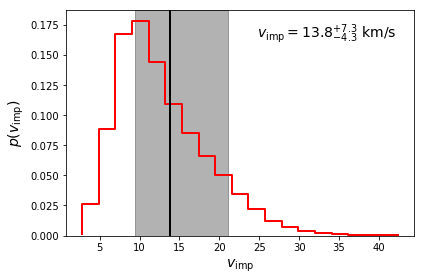

In [16]:
#Posterior probability distribution of impact velocities
data=np.loadtxt(f"{IMPACT_FIGDIR}/vimp-marginal.dat")
vimps=data[:,0]
pvs=data[:,1]
v1,vm,v2=ipercs(vimps,pvs,[15.0,50.0,85.0])
mv=v1-vm;pv=v2-vm
vimp=vm;dvimp_p=pv;dvimp_m=mv

#Plot
fig=plt.figure()
ax=fig.gca()

ax.step(vimps,pvs,color='r',lw=2)

ax.set_xlabel(r"$v_{\rm imp}$",fontsize=14)
ax.set_ylabel(r"$p(v_{\rm imp})$",fontsize=14)

ax.axvspan(v1,vm,color='k',alpha=0.3)
ax.axvline(vm,color='k',lw=2)
ax.axvspan(vm,v2,color='k',alpha=0.3)

#ax.set_title("L1-J-21 Impact Velocity",fontsize=18)

ax.text(0.95,0.95,r"$v_{\rm imp}=%.1lf^{%+.1lf}_{%+.1lf}$ km/s"%(vm,pv,mv),
        transform=ax.transAxes,ha='right',va='top',fontsize=14)

ymin,ymax=ax.get_ylim()
ax.set_ylim((0,ymax))

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-vimp-ppd.png")
plt.show();

### Incident angle statistics

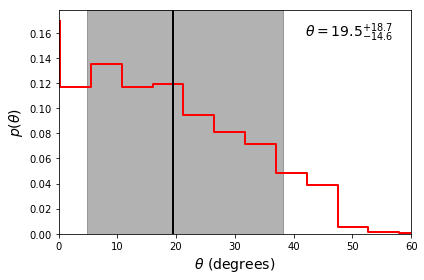

In [17]:
plt.ion()
#Posterior probability distribution of impact velocities
data=np.loadtxt(f"{IMPACT_FIGDIR}/elevation-marginal.dat")
angles=data[:,0]
pas=data[:,1]
v1,vm,v2=ipercs(angles,pas,[15.0,50.0,85.0])
mv=v1-vm;pv=v2-vm
thetamax=v2

#Figure
fig=plt.figure()
ax=fig.gca()

ax.step(angles,pas,color='r',lw=2)

ax.set_xlabel(r"$\theta$ (degrees)",fontsize=14)
ax.set_ylabel(r"$p(\theta)$",fontsize=14)

ax.axvspan(v1,vm,color='k',alpha=0.3)
ax.axvline(vm,color='k',lw=2)
ax.axvspan(vm,v2,color='k',alpha=0.3)

ax.text(0.95,0.95,r"$\theta=%.1lf^{%+.1lf}_{%+.1lf}$"%(vm,pv,mv),
        transform=ax.transAxes,ha='right',va='top',fontsize=14)

ymin,ymax=ax.get_ylim()
ax.set_ylim((0,ymax))
ax.set_xlim((0,60))

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-elevation-ppd.png")

### Distribution of Radiants

In [18]:
#Build 2D histogram
RAmin=0.0;RAmax=360;NRA=20;dRA=(RAmax-RAmin)/NRA
DECmin=-90.0;DECmax=90.0;NDEC=20;dDEC=(DECmax-DECmin)/NDEC

#Run over all combinations
hrd=np.zeros((NDEC,NRA))
pprob=data_rays_prob[:,7]

j=0
P=0
for i in tqdm(range(len(data_rays))):

    #Topocentric coordinates
    Az=data_rays[i,1]
    h=data_rays[i,0]
    p=pprob[i]

    #J2000 coordinates
    RA,DEC=loc2Sky(IMPACT_ET,Az,h,
                   IMPACT_LOC["lon"],IMPACT_LOC["lat"],IMPACT_LOC["alt"],
                   "MOON","IAU_MOON")
    #print(Az,h,RA/15,DEC)
    
    nRA=int((RA-RAmin)/dRA)
    nDEC=int((DEC-DECmin)/dDEC)

    if nRA>=NRA or nDEC>=NDEC:continue
        
    DEC=DECmin+(nDEC+0.5)*dDEC
    factor=1/np.cos(DEC*np.pi/180)
    
    P+=factor*p
    hrd[nDEC,nRA]+=factor*p
    j+=1
hrd/=P

100%|██████████| 41167/41167 [00:17<00:00, 2339.89it/s]


In [19]:
#Surface of the moon
sRA=[]
sDEC=[]
h=0
for Az in np.linspace(0,360,100):
    RA,DEC=loc2Sky(IMPACT_ET,Az,h,IMPACT_LOC["lon"],IMPACT_LOC["lat"],IMPACT_LOC["alt"],
                   "MOON","IAU_MOON")
    sRA+=[RA]
    sDEC+=[DEC]
sRA=np.array(sRA);sDEC=np.array(sDEC)

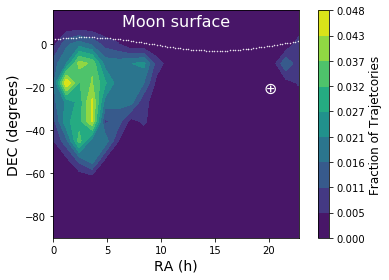

In [20]:
#Map
RAs,DECs=np.meshgrid(np.arange(RAmin,RAmax,dRA),np.arange(DECmin,DECmax,dDEC))
hrd/=hrd.sum()
hmin=hrd.min();hmax=hrd.max()

fig=plt.figure()
ax=fig.gca()

c=ax.contourf(RAs/15.0,DECs,hrd,levels=np.linspace(hrd.min(),hrd.max(),10)) #,cmap="YlOrBr")
cbar=fig.colorbar(c)
cbar.ax.set_ylabel('Fraction of Trajetcories',fontsize=12)

ytl=[]
for y in cbar.ax.get_yticks():
    ytl+=["%.3f"%(hmin+y*(hmax-hmin))]
cbar.ax.set_yticklabels(ytl)

#ax.plot(RA_EARTH,DEC_EARTH,'wo')
ax.plot(sRA/15.0,sDEC,'w.',ms=1)

ax.set_ylim((-90.0,5*max(sDEC)))
ax.set_xlim((0,RAs.max()/15.0))

ax.text(RA_EARTH,DEC_EARTH,r'$\oplus$',ha='center',va='center',color='w',fontsize=16)
ax.text(0.5,0.95,"Moon surface",ha='center',va='center',transform=ax.transAxes,color='w',fontsize=16)

ax.set_xlabel("RA (h)",fontsize=14)
ax.set_ylabel("DEC (degrees)",fontsize=14)

ax.set_aspect(0.2)
fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-RA_DEC-map.png")

In [21]:
#Identify maxima
RArad=3.07
DECrad=-23.7

### Orbital Map

In [22]:
amin=0.5;amax=2.5;Na=10;da=(amax-amin)/Na
emin=0.0;emax=1.0;Ne=10;de=(emax-emin)/Ne

hae=np.zeros((Na,Ne))
for i in tqdm(range(Nrays)):
    q=data_rays[i,9]
    e=data_rays[i,10]
    if e>=1:continue
    a=q/(1-e)
    na=int((a-amin)/da)
    ne=int((e-emin)/de)
    if na>=Na or ne>=Ne:continue
    hae[ne,na]+=1
Nt=hae.sum()

100%|██████████| 41167/41167 [00:00<00:00, 107265.18it/s]


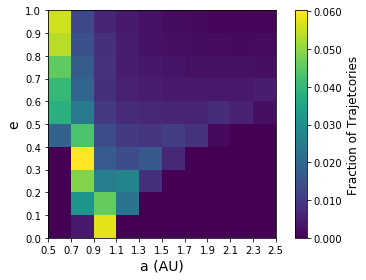

In [23]:
#Figure
hmin=hae.min()/Nt;hmax=hae.max()/Nt

A,E=np.meshgrid(np.arange(amin,amax,da),np.arange(emin,emax,de))
fig=plt.figure()
ax=fig.gca()

im=ax.imshow(hae/Nt,origin='lower')
cbar=fig.colorbar(im)
cbar.ax.set_ylabel('Fraction of Trajetcories',fontsize=12)

ytl=[]
for y in cbar.ax.get_yticks():
    ytl+=["%.3f"%(hmin+y*(hmax-hmin))]
cbar.ax.set_yticklabels(ytl)


ax.set_xlabel("a (AU)",fontsize=14)
ax.set_ylabel("e",fontsize=14)

xts=[]
xtl=[]
for i in np.arange(0.0,Na+1,1):
    xts+=[i-0.5]
    xtl+=["%.1f"%(amin+i*da)]
t=ax.set_xticks(xts)
t=ax.set_xticklabels(xtl)

xts=[]
xtl=[]
for i in np.arange(0.0,Ne+1,1):
    xts+=[i-0.5]
    xtl+=["%.1f"%(emin+i*de)]
t=ax.set_yticks(xts)
t=ax.set_yticklabels(xtl)

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-ae-map.png")

## Photometry

### Magnitude calculations

In [24]:
Gts=[]
dGts=[]
texps=[]
for key,site in sites.items():

    print(f"Fitting photometry for site {key}:")
    
    #Extract photometric data
    stars=site["data"]
    impact=stars.loc[stars["ObjName"]=="L1-21J"].iloc[0]
    stars=stars.loc[stars["type"]=="Star"]
    texps+=[site["texp"]]

    #Minimize
    coefs=deepcopy(PHOTOMETRY_COEFS)
    solution=minimize(chiSquare,coefs,args=(stars,False),tol=1e-5)

    #Test Solution
    chisq,dGs=chiSquare(solution.x,stars,verbose=True)
    dG=np.sqrt(np.mean(np.array(dGs)**2))
    print(f"\tRMS magnitude fit error:{dG}")
    
    #Determine the magnitude of the simpact
    Gt=Gmag(solution.x,impact["CountsR"],impact["CountsG"],impact["CountsB"])
    print(f"\tMagnitude without exposure correction:",Gt)
    Gts+=[Gt]
    dGts+=[dG]
    
    site["Gt"]=Gt
    site["dG"]=dG
    impact.loc["G"]=Gt

Fitting photometry for site RD:
BD+21 1766:Teo=8.332326935276292,Obs=8.3523,dM=0.019973064723707523
BD+20 2007:Teo=9.716401243841592,Obs=9.7906,dM=0.07419875615840787
HD 67564:Teo=9.214110841358224,Obs=9.0181,dM=0.19601084135822333
TYC 1385-899-1:Teo=10.096088322435435,Obs=10.0132,dM=0.08288832243543531
BD+21 1779:Teo=8.862222440980187,Obs=8.9471,dM=0.08487755901981409
BD+21 1777:Teo=9.5698938006629,Obs=9.6792,dM=0.10930619933709984
BD+20 2009:Teo=10.34659999263705,Obs=10.4423,dM=0.09570000736295015
BD+20 2005:Teo=8.665190381334455,Obs=8.6293,dM=0.03589038133445399
TYC 1385-939-1:Teo=10.421865975179573,Obs=10.3526,dM=0.06926597517957234
	RMS magnitude fit error:0.09752010282437712
	Magnitude without exposure correction: 11.682978318448377
Fitting photometry for site Georgia:
TYC 1385-116-1:Teo=10.55747389086084,Obs=10.5824,dM=0.0249261091391606
HD 68121:Teo=9.56017838210927,Obs=9.5567,dM=0.003478382109269873
TYC 1385-1052-1:Teo=9.909495928692767,Obs=10.0134,dM=0.10390407130723389
TYC 1

### Intercept calculation

In [25]:
photofitparam=[6.0]
solution=minimize(photoFit,photofitparam,args=(texps,Gts,dGts))
Go=solution.x[0]
fun=solution.fun
dGo=errorMagnitude(Go,fun,1)
print(f"Best fitted magnitude: {Go}+/-{dGo}")

Best fitted magnitude: 6.791689056124043+/-0.06182268661359558


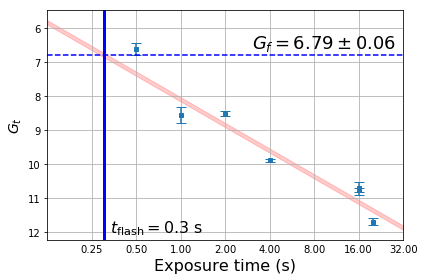

In [26]:
fig=plt.figure()
ax=fig.gca()

tmin=0.125
tmax=32.0
ts=np.linspace(tmin,tmax,10)

ax.errorbar(texps,Gts,yerr=dGts,ls='',fmt='s',ms=4,capsize=5)
ax.fill_between(ts,
               (Go+dGo)-2.5*np.log10(IMPACT_FLASH/ts),
               (Go-dGo)-2.5*np.log10(IMPACT_FLASH/ts),
               color='red',alpha=0.2)

ax.set_xscale("log")

ax.set_xlabel("Exposure time (s)",fontsize=16)
ax.set_ylabel("$G_t$",fontsize=14)

ax.axvline(IMPACT_FLASH,lw=3,color='b')
ax.axhline(Go,ls='--',color='b')

ax.set_xlim((tmin,tmax))
ax.text(1.1*0.3,12,r"$t_{\rm flash}=0.3$ s",fontsize=16,ha='left')
ax.text(0.9*tmax,Go-dGo,f"$G_f={Go:.2f}\pm{dGo:.2f}$",ha='right',va='bottom',fontsize=18)

ax.set_xticks([0.25,0.5,1.0,2.0,4.0,8.0,16.0,32.0])
ax.get_xaxis().set_tick_params(which='minor', size=0)
ax.get_xaxis().set_tick_params(which='minor', width=0) 
ax.get_xaxis().set_tick_params(which='major', size=0)
ax.get_xaxis().set_tick_params(which='major', width=0) 
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.invert_yaxis()
ax.grid()

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-Gmag-time.png")

## Energy of the impact

In [27]:
#Luminous energy
fany=2
Er=NG*10**((-Go+G0)/2.5)*DLAMBDA*fany*np.pi*(MOON_DISTANCE*1e3)**2*IMPACT_FLASH
logEr=np.log10(Er)
dlogEr=dGo/Go*logEr
print(f"Luminous energy (log): {logEr} +/- {dlogEr}")
#Kinetic energy
logK=logEr-logeta_mean
dlogK=np.sqrt(dlogEr**2+dlogeta**2)
print(f"Kinetic energy (log): {logK} +/- {dlogK}")
Kton_m=10**(logK-dlogK)/TTNT
Kton_p=10**(logK+dlogK)/TTNT
print(f"Range of kinetic energy in tons: {Kton_m}-{Kton_p} tons of TNT")

Luminous energy (log): 6.699334507611363 +/- 0.06098201115527329
Kinetic energy (log): 9.305958796538583 +/- 0.1509678812979402
Range of kinetic energy in tons: 0.3415067085572129-0.6844394001114759 tons of TNT


## Meteoroid and crater size

### Random values of primary quantities 

In [28]:
#Generate random values of the key quantities
N=1000
#Random kinetic energy
logKs=np.random.normal(logK,dlogK,N)
Ks=10**logKs
#Random impact speed
vrs=randomX(vimps,pvs,N)
#Random impact angle
thetas=randomX(angles,pas,N)
#Random densities
u=np.random.rand(N)
rhos=np.zeros(N)

RHO_COMET=1000
P_COMET=0.01
RHO_ROCKY=2500
P_ROCKY=0.59
RHO_METAL=3700
P_METAL=1-P_COMET-P_ROCKY

rhos[(u<0.01)]=RHO_COMET
rhos[(u>=0.01)*(u<0.59)]=RHO_ROCKY
rhos[(u>=0.59)]=RHO_METAL

### Derived quantities

In [29]:
#Mass
Ms=2*Ks/(vrs*1e3)**2
logMs=np.log10(Ms)
#Diameter
Ds=2*(3*Ms/(3*np.pi*rhos))**(1./3)
#Crater diameter
dcs=0.25*rhos**(1./6.)*RHO_REG**(-0.5)*Ks**0.29*(np.sin(thetas*DEG))**(1./3.)

In [30]:
#Basic statistics
print(f"Median impactor mass: {np.percentile(Ms,50)} kg")
print(f"Median impactor diameter: {np.percentile(Ds,50)} m")
print(f"Median crater size: {np.percentile(dcs,50)} m")

Median impactor mass: 21.621798093430563 kg
Median impactor diameter: 0.26616549845418414 m
Median crater size: 8.100714641783732 m


### Posterior probability distributions

Generating statistics of logMs...
	Value: $\log(M)$$=1.3^{+0.40}_{-0.37}$ [kg]
	Creating figure file .//data/L1-21J/l21j-logMs-ppd.png


/Users/jzuluaga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


Generating statistics of Ds...
	Value: $D$$=0.3^{+0.07}_{-0.09}$ m
	Creating figure file .//data/L1-21J/l21j-Ds-ppd.png
Generating statistics of dcs...
	Value: $d$$=8.1^{+3.08}_{-2.11}$ m
	Creating figure file .//data/L1-21J/l21j-dcs-ppd.png


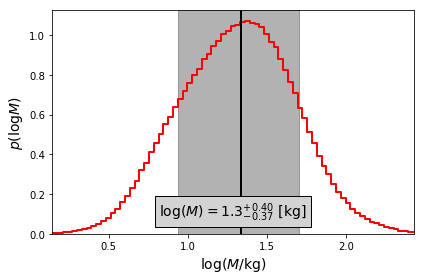

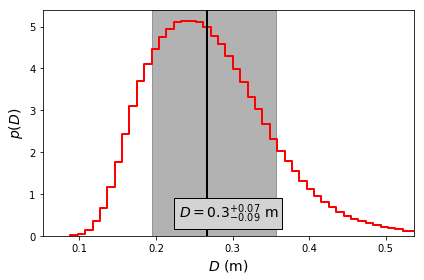

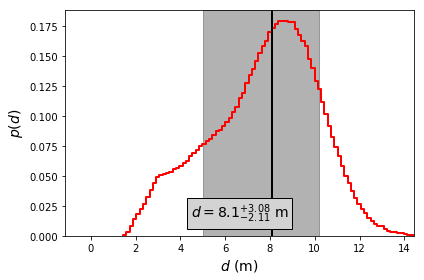

In [31]:
properties=[
    dict(name="$\log(M)$",units="[kg]",symbol="logMs",xlabel=r"$\log(M/{\rm kg})$",ylabel=r"$p(\log M)$"),
    dict(name="$D$",units="m",symbol="Ds",xlabel=r"$D$ (m)",ylabel=r"$p(D)$"),
    dict(name="$d$",units="m",symbol="dcs",xlabel=r"$d$ (m)",ylabel=r"$p(d)$"),
]
plt.ioff()
for q in properties[:]:
    
    print(f"Generating statistics of {q['symbol']}...")
    
    #Statistics
    exec(f"vs=deepcopy({q['symbol']})")
    exec(f"hs,xs=np.histogram({q['symbol']},100,normed=True)")
    xms=(xs[1:]+xs[:-1])/2
    #Error
    x1,xm,x2=np.percentile(vs,[15,50,85])
    mv=xm-x1;pv=x2-xm
          
    if q["symbol"]=="logMs":
          logMs_val=xm
          dlogMs_m=x1-xm
          dlogMs_p=x2-xm
    elif q["symbol"]=="Ds":
          Ds_val=xm
          dDs_m=x1-xm
          dDs_p=x2-xm
    elif q["symbol"]=="dcs":
          dcs_val=xm
          ddcs_m=x1-xm
          ddcs_p=x2-xm

    #Plot distributions
    fig=plt.figure()
    ax=fig.gca()
    ax.step(xms,hs,color='r',lw=2)

    ax.set_xlabel(q["xlabel"],fontsize=14)
    ax.set_ylabel(q["ylabel"],fontsize=14)

    ax.axvspan(x1,xm,color='k',alpha=0.3)
    ax.axvline(xm,color='k',lw=2)
    ax.axvspan(xm,x2,color='k',alpha=0.3)

    value=r"%s$=%.1lf^{+%.2lf}_{-%.2f}$ %s"%(q["name"],xm,mv,pv,q["units"])
    print(f"\tValue: {value}")
    ax.text(0.5,0.1,value,
            transform=ax.transAxes,ha='center',va='center',fontsize=14,bbox=dict(facecolor='lightgray'))

    ymin,ymax=ax.get_ylim()
    ax.set_ylim((0,ymax))
    ax.set_xlim((x1-2*mv,x2+2*pv))
    fname=f"{IMPACT_FIGDIR}/l21j-{q['symbol']}-ppd.png"
    print(f"\tCreating figure file {fname}")
    fig.savefig(fname)
    fig.tight_layout()
    del(fig)


Mmin=10**(logMs_val+dlogMs_m)
Mmax=10**(logMs_val+dlogMs_p)
Dmin=Ds_val+dDs_m
Dmax=Ds_val+dDs_p
dmin=dcs_val+ddcs_m
dmax=dcs_val+ddcs_p

## Generate paper content

### Macros

In [32]:
#First set of 
f=open(f"{IMPACT_FIGDIR}/macros-results.tex","w")

f.write("\\newcommand{\\vimpvalue}{%.1f^{%+.1f}_{%+.1f}} %s%%km/s\n"%(vimp,dvimp_p,dvimp_m,""))
f.write("\\newcommand{\\thetamax}{%.1f} %s%%deg\n"%(thetamax,""))
f.write("\\newcommand{\\Erel}{%s} %s%%log J\n"%(val2Exp(Er,fmt="%.0f",text=True),""))
f.write("\\newcommand{\\tflash}{%.1f} %s%%s \n"%(IMPACT_FLASH,""))
f.write("\\newcommand{\\Eimp}{%.1f-%.1f} %s%%tons of TNT\n"%(Kton_m,Kton_p,""))
f.write("\\newcommand{\\Mrange}{%.0f-%.0f} %s%%kg\n"%(Mmin,Mmax,""))
f.write("\\newcommand{\\Drange}{%.0f-%.0f} %s%%cm\n"%(100*Dmin,100*Dmax,""))
f.write("\\newcommand{\\craterRange}{%.0f-%.0f} %s%%m\n"%(dmin,dmax,""))
f.write("\\newcommand{\\flashtime}{%s}%s\n"%(IMPACT_TIME,""))
f.write("\\newcommand{\\etarange}{%g-%g} %s%%adim.\n"%(eta_min,eta_max,""))
f.write("\\newcommand{\\logeta}{%.2f\pm%.2f} %s%%log\n"%(logeta_mean,dlogeta,""))

#Position by visual inspection
f.write("\\newcommand{\\latvisual}{%.2f} %s%%deg\n"%(IMPACT_LOC["lat"],""))
f.write("\\newcommand{\\lonvisual}{%.2f} %s%%deg\n"%(IMPACT_LOC["lon"],""))

#Position by geometrical procedure
f.write("\\newcommand{\\latgeo}{%+.2f^{%+.2f}_{%+.2f}} %s%%deg\n"%(latGeo,dlatGeo_p,dlatGeo_m,""))
f.write("\\newcommand{\\longeo}{%+.2f^{%+.2f}_{%+.2f}} %s%%deg\n"%(lonGeo,dlonGeo_p,dlonGeo_m,""))

#Position by paralax
f.write("\\newcommand{\\latpar}{%.2f\pm 0.20} %s%%deg\n"%(Impact["slat"],""))
f.write("\\newcommand{\\lonpar}{%.2f\pm 0.08} %s%%deg\n"%(Impact["slon"],""))

#Radiant
f.write("\\newcommand{\\RArad}{%.1f} %s%%h\n"%(RArad,""))
f.write("\\newcommand{\\DECrad}{%.1f} %s%%deg\n"%(DECrad,""))

f.write("\\newcommand{\\Gf}{%.2f \pm %.2f} %s%%mag\n"%(Go,dGo,""))

#Energy estimation
f.write("\\newcommand{\\Moondist}{%g} %s%%km\n"%(MOON_DISTANCE,""))
f.write("\\newcommand{\\bG}{%s} %s%%bG\n"%(val2Exp(NG,fmt="%.1f",text=True),""))
f.write("\\newcommand{\\Go}{%g} %s%%G0\n"%(G0,""))
f.write("\\newcommand{\\deltaLambda}{%.3f} %s%%nm\n"%(DLAMBDA,""))
f.write("\\newcommand{\\fany}{%g} %s%%adim\n"%(fany,""))

#Result of the energy
f.write("\\newcommand{\\logEr}{%.1f\pm %.3f} %s%%logJ\n"%(logEr,dlogEr,""))
f.write("\\newcommand{\\logK}{%.2f\pm %.2f} %s%%logJ\n"%(logK,dlogK,""))
f.write("\\newcommand{\\rhoRegolith}{%g} %s%%g/cc\n"%(RHO_REG,""))
f.write("\\newcommand{\\rhoMin}{%g} %s%%g/cc\n"%(RHO_COMET,""))
f.write("\\newcommand{\\rhoMax}{%g} %s%%g/cc\n"%(RHO_METAL,""))
f.write("\\newcommand{\\rhoComet}{%g} %s%%g/cc\n"%(RHO_COMET,""))
f.write("\\newcommand{\\pComet}{%.1f} %s%%percentage\n"%(100*P_COMET,""))
f.write("\\newcommand{\\rhoRocky}{%g} %s%%g/cc\n"%(RHO_ROCKY,""))
f.write("\\newcommand{\\pRocky}{%.0f} %s%%percentage\n"%(100*P_ROCKY,""))
f.write("\\newcommand{\\rhoMetal}{%g} %s%%g/cc\n"%(RHO_METAL,""))
f.write("\\newcommand{\\pMetal}{%.0f} %s%%percentage\n"%(P_METAL,""))

#Geocentric position of the impact
f.write("\\newcommand{\\RAgeo}{%.5f} %s%%h\n"%(Impact["RAgeo"],""))
f.write("\\newcommand{\\DECgeo}{%.5f} %s%%deg\n"%(Impact["DECgeo"],""))
f.write("\\newcommand{\\Dimpgeo}{%.0f} %s%%deg\n"%(Impact["Distance"]*REARTH,""))


#Geocentric position of the lunar center
f.write("\\newcommand{\\RAcen}{%.5f} %s%%h\n"%(Center["RAgeo"],""))
f.write("\\newcommand{\\DECcen}{%.5f} %s%%deg\n"%(Center["DECgeo"],""))
f.write("\\newcommand{\\Dcengeo}{%.0f} %s%%deg\n"%(Center["Distance"]*REARTH,""))

#NASA SPICE NAIF position
f.write("\\newcommand{\\RAcenNASA}{%.5f} %s%%h\n"%(RA_MOON,""))
f.write("\\newcommand{\\DECcenNASA}{%.5f} %s%%deg\n"%(DEC_MOON,""))
f.write("\\newcommand{\\DcenNASA}{%g} %s%%deg\n"%(MOON_DISTANCE,""))
        
f.close()

### Observations

In [33]:
#First set of 
f=open(f"{IMPACT_FIGDIR}/tab-observations.tex","w")

f.write("""%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
%REFERENCE STARS TABLE
\\begin{table*}
\\centering
\\resizebox{\\textwidth}{!}{%
\\begin{tabular}{c|cc|rrr|rrr|rr}
\\hline\\hline
Star name & 
\\multicolumn{2}{c|}{Sky Position$^\\dagger$} & 
\\multicolumn{3}{c|}{Magnitudes} & 
\\multicolumn{3}{c|}{Counts (AP$^{\\dagger\\dagger}$)} & 
\\multicolumn{2}{c}{Coordinates}\\\\
 & RA & DEC & B & V & G$^\\ddagger$ & Red & Green & Blue & X & Y\\\\
\\hline
""")
for keys in ["RD","Georgia","CapeVerde","CanaryIslands"]:
    site=sites[keys]
    data=site["data"]
    f.write("""
\\hline
\\multicolumn{11}{c}{%s}\\\\
\\hline
"""%keys)
    for ind,star in data.loc[data["type"]=="Star"].iterrows():
        row=f"{star.ObjName} & "
        comment=""
        for field in "RA","DEC","B","V","G","CountsR","CountsG","CountsB","X","Y":
            value=star[field]
            if value==-1:
                value="-"
            if field=="RA" or field=="DEC":
                row+=f"{value:.5f}{comment} & "
            elif field=="X" or field=="Y":
                row+=f"{value:.0f}{comment} & "
            elif field=="B" or field=="V" or field=="G":
                row+=f"{value:.2f}{comment} & "
            else:
                row+=f"{value}{comment} & "
        row=row.strip(" & ")
        row+="\\\\\n"
        f.write(row)

    star=data.loc[data["ObjName"]=="L1-21J"].iloc[0]
    comment=""
    row=f"{star.ObjName} & "
    for field in "RA","DEC","B","V","G","CountsR","CountsG","CountsB","X","Y":
        value=star[field]
        if value==-1:
            value="-"
        if field=="RA" or field=="DEC":
            comment="*"
            row+=f"{value:.4f}{comment} & "
        elif field=="X" or field=="Y":
            row+=f"{value:.0f}{comment} & "
        else:
            comment=""
            row+=f"{value}{comment} & "
    row=row.strip(" & ")
    row+="\\\\\n"
    f.write(row)

f.write("""
\\hline
\\multicolumn{11}{c}{\\it Continues in Table \\ref{tab:referencestars2}}\\\\
\\hline\\hline
\\multicolumn{11}{l}{\\footnotesize $^\\ddagger$ J2000, $^\\ddagger$ Gaia G-magnitude, $^{\\dagger\\dagger}$ Aperture photometry}\\\\
\\multicolumn{11}{l}{\\footnotesize $^*$ Calculated coordinates (see Section \\ref{sec:parallax})}\\\\
\\end{tabular}}
\\caption{Reference stars properties, photometry and astrometry results for the pictures analysed in this work.\\label{tab:referencestars1}}
\\end{table*}
""")


f.write("""%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
%REFERENCE STARS TABLE
\\begin{table*}
\\centering
\\resizebox{\\textwidth}{!}{%
\\begin{tabular}{c|cc|rrr|rrr|rr}
\\hline\\hline
Star name & 
\\multicolumn{2}{c|}{Sky Position$^\\dagger$} & 
\\multicolumn{3}{c|}{Magnitudes} & 
\\multicolumn{3}{c|}{Counts (AP$^{\\dagger\\dagger}$)} & 
\\multicolumn{2}{c}{Coordinates}\\\\
 & RA & DEC & B & V & G$^\\ddagger$ & Red & Green & Blue & X & Y\\\\
\\hline
\\hline
\\multicolumn{11}{c}{\\it Continued from Table \\ref{tab:referencestars1}}\\\\
""")
for keys in ["Germany","Czech","Vienna"]:
    site=sites[keys]
    data=site["data"]
    f.write("""
\\hline
\\multicolumn{11}{c}{%s}\\\\
\\hline
"""%keys)
    for ind,star in data.loc[data["type"]=="Star"].iterrows():
        row=f"{star.ObjName} & "
        comment=""
        for field in "RA","DEC","B","V","G","CountsR","CountsG","CountsB","X","Y":
            value=star[field]
            if value==-1:
                value="-"
            if field=="RA" or field=="DEC":
                row+=f"{value:.5f}{comment} & "
            elif field=="X" or field=="Y":
                row+=f"{value:.0f}{comment} & "
            elif field=="B" or field=="V" or field=="G":
                row+=f"{value:.2f}{comment} & "
            else:
                row+=f"{value}{comment} & "
        row=row.strip(" & ")
        row+="\\\\\n"
        f.write(row)

    star=data.loc[data["ObjName"]=="L1-21J"].iloc[0]
    comment=""
    row=f"{star.ObjName} & "
    for field in "RA","DEC","B","V","G","CountsR","CountsG","CountsB","X","Y":
        value=star[field]
        if value==-1:
            value="-"
        if field=="RA" or field=="DEC":
            comment="*"
            row+=f"{value:.4f}{comment} & "
        elif field=="X" or field=="Y":
            row+=f"{value:.0f}{comment} & "
        else:
            comment=""
            row+=f"{value}{comment} & "
    row=row.strip(" & ")
    row+="\\\\\n"
    f.write(row)

f.write("""
\\hline\\hline
\\end{tabular}}
\\caption{Continuation of Table \\ref{tab:referencestars1}.\\label{tab:referencestars2}}
\\end{table*}
""")

f.close()

### Observing sites

In [34]:
#First set of 
f=open(f"{IMPACT_FIGDIR}/tab-locations.tex","w")

f.write("""
%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
%ASTROMETRY
\\begin{table*}
\\centering
\\resizebox{\\textwidth}{!}{\\begin{tabular}{cccccccc}
\\hline\\hline
Location & Latitude & Longitude & Elevation & Exposure time & Flash magnitude$^\\dagger$ & Apparent Position$^\\ddagger$ &  Selenographic Coordinates$^\\ddagger$ \\\\
 & (deg) & (deg) & (m) & (seconds) & (G magnitude) & J2000(RA, Dec) & (Lat., Lon.) \\\\\\hline
""")

for key,site in sites.items():
    data=site["data"]
    locname=site["location"].replace(" (","\\\\(")
    impact=data.loc[data["ObjName"]=="L1-21J"].iloc[0]
    row=f"{locname} & {site['lat']:.5f} & {site['lon']:.5f} & {site['alt']} & {site['texp']} & ${site['Gt']:.2f}\\pm {site['dG']:.2f}$ & ({impact['RA']:.4f},{impact['DEC']:.4f}) & ({site['ImpactLat']:.2f},{site['ImpactLon']:.2f})\\\\%\\hline\n"
    f.write(row)

f.write("""
\\hline\\hline
\\multicolumn{8}{l}{$^\\dagger$ Section \\ref{sec:energy}, $^\\ddagger$ Section \\ref{sec:location}.}
\\end{tabular}}
\\caption{\\hl{Porperties of the images analized in this work.}\\label{tab:locations}}
\\end{table*}
%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
""")

f.close()

### Reference Lunar Features

In [35]:
#First set of 
f=open(f"{IMPACT_FIGDIR}/tab-lunar.tex","w")

f.write("""
%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
%LUNAR SURFACE FEATURES TABLE
\\begin{table*}
\\centering
\\begin{tabular}{cccc}
\\hline\\hline
Surface Feature & Selenographic Coordinates & Geocentric Position$^\\dagger$ & Distance$^\\dagger$ \\\\
                & (Lat.,Lon.)               & J2000 (RA,Dec)      & (km)     \\\\\\hline
""")

for ind,lunarsite in LunarSites.iterrows():
    comment=""
    
    coordinates=f"({lunarsite['slat']:.2f},{lunarsite['slon']:.2f})"
    if lunarsite["LunarSite"]=="L1-21J":
        comment="$^\\ddagger$"
    if "Center" in lunarsite["LunarSite"]:
        coordinates=f"-"
    f.write(f"{lunarsite['LunarSite']} & {coordinates}{comment} & ({lunarsite['RAgeo']:.4f},{lunarsite['DECgeo']:.4f}) & {REARTH*lunarsite['Distance']:.0f}\\\\\n")
    
f.write("""
\\hline\\hline
\\multicolumn{4}{l}{\\footnotesize $^\\dagger$ Calculated geocentric coordinates and distance (see Section \\ref{sec:parallax})}\\\\
\\multicolumn{4}{l}{\\footnotesize $^\\ddagger$ Calculated with our geometrical procedure (see Section \\ref{subsec:geolocation})}\\\\
\\end{tabular}
\\caption{Lunar features reference points and their selenographic coordinates, along with the apparent geocentric equatorial coordinate RA, Dec and geocentric distance results from parallax analysis.}
\\label{tab:surfacefeatures}
\\end{table*}
%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
""")
f.close()